# Tracklet extraction

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import numpy as np
import glob
import os

from tqdm.auto import tqdm

from astropy.table import Table, vstack
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord, concatenate, get_sun
from fastparquet import ParquetFile


from fink_science.conversion import dc_mag

/Users/julien/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


## Tracklet identification

Let's load the raw tracklet data from Fink (initial candidates) for the year 2020

In [25]:
# change for different dates
basepath = 'ufo_fink_2019_consolidated/'

filename = glob.glob(os.path.join(basepath, 'part-*.parquet'))
pdt = pd.read_parquet(filename[0]) 
#ParquetFile(filename[0]).to_pandas()

table = Table.from_pandas(pdt)

# We keep only candidates with 1 detection
table = table[table['ndethist'] == 1]
len(table)

127442

Based on Sergey's analysis, let's limit the analysis to the candidates outside the locus of bad subtractions

In [26]:
idx = table['magnr'] - table['magpsf'] < 3.0*np.hypot(table['sigmagnr'], table['sigmapsf'])
idx &= table['magnr'] - table['magpsf'] < -4*(np.log10(table['distnr']) + 0.2)
idx &= table['distnr'] < 2

table1 = table[~idx]

Let's now extract all groups of candidates laying along great circles - tracklets -- having at least 5 points using Sergey's extraction method. The criterion will be the distance from great circle less than 1 arcsecond. As a candidate circles, we will use all possible circles passing through pairs of points.

In [31]:
N = 0

# Boolean
table1['tracklet'] = False

# String - container for tracklet designation
tracklet_numbers = np.zeros_like(table1['tracklet'], dtype='U20')

tracklets = []
nids = []

key = 'nid' # Analyse night at once
# key = 'jd' # Analyse single frames

for nid in tqdm(sorted(np.unique(table1[key]))[:]):
    idx = table1[key] == nid
    print(nid)
    
    # nid=1294 seems buggy (2020-07-18)
    if nid in [1294, 1045, 1046]:
        continue

    sub = table1[idx] # Subset of objects from this exposure
    coords = SkyCoord(sub['ra'], sub['dec'], unit='deg') # Coordinates of the objects
    xyz = coords.cartesian
    xyz = xyz.xyz.value.T # unit vectors corresponding to the points, Nx3
    
    if len(sub) < 5:
        continue

    # Levi-Civitta symbol
    eijk = np.zeros((3, 3, 3))
    eijk[0, 1, 2] = eijk[1, 2, 0] = eijk[2, 0, 1] = 1
    eijk[0, 2, 1] = eijk[2, 1, 0] = eijk[1, 0, 2] = -1

    circles = np.einsum('ijk,uj,vk->uvi', eijk, xyz, xyz, optimize=True) # cross-products, NxNx3
    norms = np.sqrt(np.einsum('uvi,uvi->uv', circles, circles, optimize=True)) # norms, i.e. arc sine lengths, NxN
    norms = np.tril(norms) # Remove redundant entries corresponding to the symmetry on point swapping

    norm_idx = norms > 10/206265 # Pairs with angular separation larger than 10 arcsec, NxN
    
    circles[norms==0,:] = 0
    circles[norms>0,:] /= norms[norms>0,np.newaxis] # normals to great circles, NxNx3

    cidxs = [] # Sets of points along great circles 
    
    for i,point in enumerate(xyz):
        sindists = np.einsum('vi,ki->vk', circles[i], xyz, optimize=True) # sine distance from the great circle
        sin_idx = np.abs(sindists) < 1/206265 # Good distances from great circles, NxN

        nps = np.einsum('uv->u', (norm_idx[i,:,np.newaxis] & sin_idx).astype(np.int8), optimize=True) # Numbers of points along each great circle, N
        np_idx = nps >= 5

        cidxs += list(sin_idx[np_idx])
        
    uniq = np.unique(cidxs, axis=0)
    aidx = np.argsort([-np.sum(_) for _ in uniq])

    used = np.zeros(len(sub), dtype=bool)
    
    index_tracklet = 0
    for cidx in uniq[aidx]:
        # First we need to reject the tracklets mostly superceded by longer ones
        if np.sum(cidx[~used]) < 5: 
            # TODO: should we try to greedily merge the extra points into already known tracks?
            continue 

        tracklet_positions = np.where(idx)[0][cidx]
        
        used[cidx] = True
        nids.append(nid)

        N += 1

        table1['tracklet'][tracklet_positions] = True

        tracklet_numbers[tracklet_positions] = 'TRCK{}_{:02d}'.format(nid, index_tracklet)
        index_tracklet += 1

        tracklets.append(tracklet_positions)
        
# Designation
table1['tracklet_number'] = tracklet_numbers

# Index for candidates belonging to tracklets
cidx = table1['tracklet'] 

  0%|          | 0/39 [00:00<?, ?it/s]

1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1057
1058
1059
1060
1065
1066
1069
1073
1074
1075
1076
1077
1079
1080
1081
1082
1083
1084
1092
1093


## Number of tracklets

In [32]:
n_tracklets = len(np.unique(table1[cidx]['tracklet_number']))
n_nights = len(np.unique(nids))

print('Number of unique tracklets found: {} (check N={})'.format(n_tracklets, N))
print('Number of unique nights with tracklets: {}'.format(n_nights))

Number of unique tracklets found: 141 (check N=141)
Number of unique nights with tracklets: 31


## Tracklet sizes

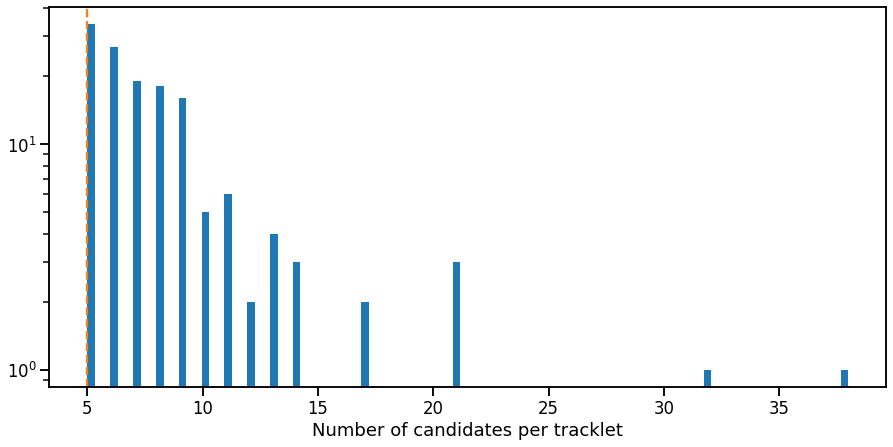

In [33]:
fig = plt.figure(figsize=(15, 7))

tracklet_sizes = np.array([len(_) for _ in table1[cidx].group_by('tracklet_number').groups])

plt.hist(tracklet_sizes, bins=100)
plt.axvline(5, ls='--', color='C1')
plt.yscale('log')
plt.xlabel('Number of candidates per tracklet');
# print(np.min(tracklet_sizes), np.median(tracklet_sizes), np.max(tracklet_sizes))

In [34]:
# check to see if all tracklets have size >= 5
tracklet_names = np.array([_['tracklet_number'][0] for _ in table1[cidx].group_by('tracklet_number').groups])
tracklet_names[tracklet_sizes < 5]

array([], dtype='<U11')

## Store tracklet data on disk

In [35]:
data = table1[cidx]
data.to_pandas().to_parquet(os.path.join(basepath, 'tracklets.parquet'))

In [9]:
# check all went good
# import pandas as pd
# pd.read_parquet(os.path.join(basepath, 'tracklets.parquet'))